In [ ]:
import torch
import numpy as np
from torch import nn 
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
imiona = open("imionapl.txt", encoding = "UTF-8").read().splitlines()
imiona = [i.lower() for i in imiona]
imiona[:5]

['ada', 'adalbert', 'adam', 'adela', 'adelajda']

In [ ]:
chars = sorted(list(set(''.join(imiona))))
stoi = {s:i +1  for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i :s for s, i in stoi.items()}

In [ ]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'y',
 24: 'z',
 25: 'ó',
 26: 'ę',
 27: 'ł',
 28: 'ń',
 29: 'ś',
 30: 'ż',
 0: '.'}

In [ ]:
block_size = 3 
def build_dataset(words):  
  X, Y = [], []
  for w in words:

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(42)
random.shuffle(imiona)
n1 = int(0.8*len(imiona))
n2 = int(0.9*len(imiona))

X_train, Y_train = build_dataset(imiona[:n1])
X_dev, Y_dev = build_dataset(imiona[n1:n2])
X_test, Y_test = build_dataset(imiona[n2:])
    

torch.Size([3919, 3]) torch.Size([3919])
torch.Size([510, 3]) torch.Size([510])
torch.Size([480, 3]) torch.Size([480])


In [ ]:
#building lookup table
C = torch.randn((31,2))

In [ ]:
emb = C[X_train]
emb.shape

torch.Size([3919, 3, 2])

In [ ]:
W1 = torch.randn((6,100))
b1 = torch.rand(100)

In [ ]:
emb = emb.view(-1,6) #matching sizes
h = torch.tanh(emb @ W1 + b1)
h.shape

torch.Size([3919, 100])

In [ ]:
W2 = torch.randn((100, 31))
b2 = torch.randn(31)

logits = h @ W2 + b2
logits.shape

torch.Size([3919, 31])

###softmax


$\sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$

In [ ]:
#softmax
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([3919, 31])


log - the natural log

y - binary indicator (0 or 1) if class label c is the correct classification for observation o

p - predicted probability observation o is of class c


$NLL(y) = -{\log(p(y))}$


In [ ]:
loss = -prob[torch.arange(prob.shape[0]), Y_train].log().mean()
loss

tensor(14.8177)

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((31, 10), generator=g) #10D space
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 31), generator=g)
b2 = torch.randn(31, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
# will be using F.cross_entropy instead of calculationg it by hand (counts, prob)
loss_2 = F.cross_entropy(logits, Y_train)
loss, loss_2

(tensor(14.8177), tensor(14.8177))

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

12741

In [ ]:
for p in parameters:
  p.requires_grad = True

25.506378173828125
12.213452339172363
7.9677276611328125
5.938740253448486
4.950891494750977
4.997961521148682
3.6560757160186768
3.9922499656677246
5.355339527130127
3.618809223175049
2.9340624809265137
3.6104519367218018
3.8376786708831787
3.0071003437042236
2.8485002517700195
1.855127215385437
2.8497231006622314
3.0861971378326416
2.574385643005371
2.232125997543335
3.738973379135132


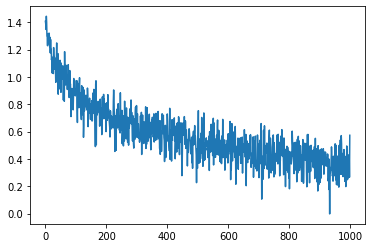

In [ ]:
epochs = 1000
losses = []
steps = []
lri = [] #to determine reasonable learning rate
for i in range(epochs):
    #minibatch index
    ix = torch.randint(0, X_train.shape[0], (32,))
    
    #forward
    emb = C[X_train[ix]] #(32, 3, 10)
    h = emb.view(-1,30) @ W1 + b1 #(32,200)
    h_act = torch.tanh(h)
    logits = h_act @ W2 + b2 #(32,30)
    loss = F.cross_entropy(logits, Y_train[ix])
    if i % 50 == 0:
        print(loss.item())
    
    #backward 
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.15 * p.grad
    # track stats
    #lri.append(lre[i]) 
    steps.append(i)
    losses.append(loss.log10().item()) #log scale 
plt.plot(np.arange(epochs), losses)
print(loss.item())
    
    

In [ ]:
emb = C[X_dev] # (510, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (510, 100)
logits = h @ W2 + b2 # (510, 31)
loss_dev = F.cross_entropy(logits, Y_dev)
print(f"devset loss :{loss_dev.item()}")

torch.Size([510, 3, 10])
torch.Size([510, 31])
devset loss :4.3615875244140625


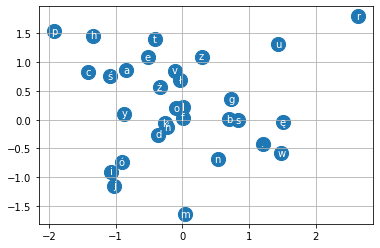

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all chars
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(214)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

choscaon.
alianard.
alerian.
galdrianard.
lilton.
alerianard.
llest.
ranttzard.
wirginikabrieta.
llesłat.
ragnsrnna.
amanuer.
lunina.
baladia.
ilagnsrnna.
luabl.
różtopelu.
ludwasylwandra.
sonśtlioliusz.
galdrsknśtasz.
